In [1]:
%pylab inline
import uuid
import base64
import cPickle as pickle
import seaborn as sns
import pandas as pd
sns.set_style('whitegrid')
import os

Populating the interactive namespace from numpy and matplotlib


In [20]:
data = pickle.load(open("reuse_explore.exp.pickle", 'r'))



In [21]:
res = []
for d in data:
    invoke_df = pd.DataFrame(d['results'])
    results_df = pd.DataFrame(d['run_statuses'])
    results_df = pd.concat([results_df, invoke_df], axis=1)
    results_df['exp_i'] = d['exp_i']
    res.append(results_df)

In [22]:
allres_df = pd.concat(res)

(1, 100000.0)

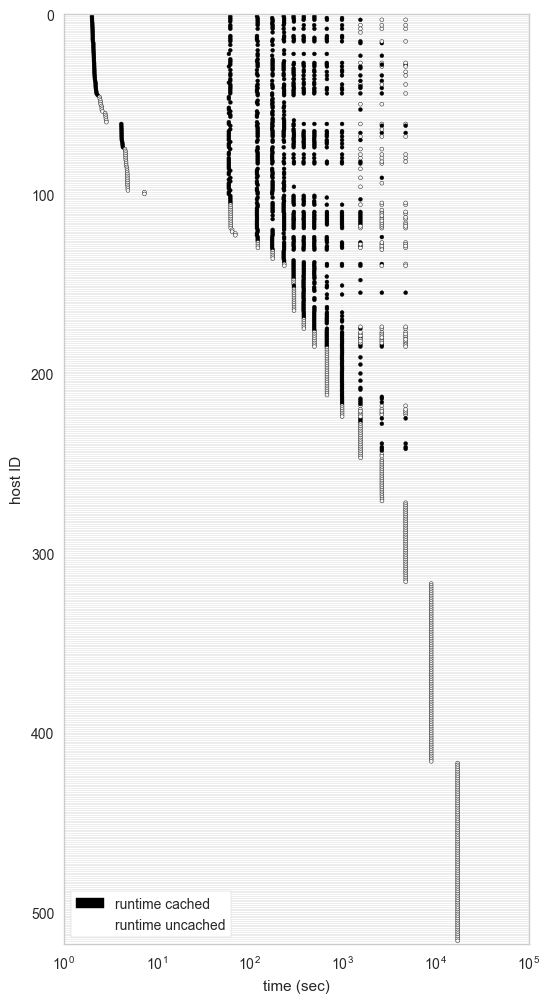

In [23]:
# timeline
min_time = np.min(allres_df.start_time) -2
s = allres_df.sort_values('start_time')
# create map 
list_of_hw_addr = s['hw_addr'].unique()
HOSTN = len(list_of_hw_addr)
hw_to_pos = {h : i for i, h in enumerate(list_of_hw_addr)}
s['hw_pos'] = s['hw_addr'].apply(lambda x: hw_to_pos[x])

point_size = 4e3/HOSTN
fig = pylab.figure(figsize=(6, 12))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(s['start_time'] - min_time, s.hw_pos, c=s.runtime_cached, s=point_size)
ax.grid()
ax.set_xlabel("time (sec)")
if HOSTN < 50:
    ax.set_yticks(range(len(list_of_hw_addr)))
    ax.set_yticklabels(list_of_hw_addr, fontsize=5,
                       fontname='Bitstream Vera Sans Mono')
for i in range(len(list_of_hw_addr)):
    ax.axhline(i, c='k', alpha=0.1, linewidth=0.5)
ax.set_ylim(len(list_of_hw_addr)+1, -1)
ax.set_ylabel("host ID")



import matplotlib.patches as mpatches

cached_patch = mpatches.Patch(color='k', label='runtime cached')
uncached_patch = mpatches.Patch(color='w', label='runtime uncached')

legend = pylab.legend(handles=[cached_patch, uncached_patch, ],
                      loc='lower left', frameon=True)
#legend.get_frame().set_facecolor('#FFFFFF')
ax.set_xscale('log')
ax.set_xlim(1, 1e5)

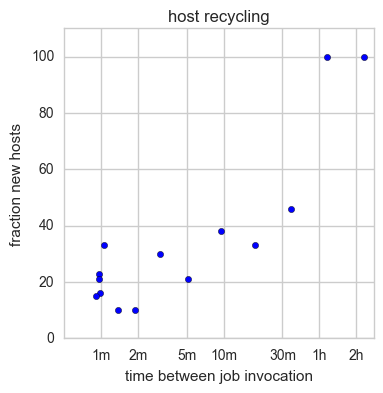

In [24]:
# how many are reused:
res = []
for i in range(1, max(allres_df.exp_i)+1):
    from_i = i-1
    to_i = i
    a = allres_df[allres_df.exp_i == from_i]
    b = allres_df[allres_df.exp_i == to_i]
    a_time = np.mean(a.start_time)
    b_time = np.mean(b.start_time)
    new_hosts = set(a.hw_addr) - set(b.hw_addr)
    res.append({'delay' : b_time-a_time, 
               'new_hosts' : len(new_hosts)})
new_host_df = pd.DataFrame(res)
fig = pylab.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(new_host_df.delay, new_host_df.new_hosts)
ax.set_xscale('log')
ax.set_ylabel("fraction new hosts")
ax.set_ylim(0, 110)
ax.set_xticks(np.array([1, 2, 5, 10, 30, 60, 120, 60*3])*60)
ax.set_xticklabels(['1m', '2m', '5m', '10m', '30m', '1h', '2h', '3h'])
ax.set_xlabel("time between job invocation")
ax.set_xlim(30, 10000)
ax.set_title("host recycling")

In [7]:
# examine latency
a = []
for ri, r in allres_df.iterrows():
    for server, offsets in r.ntp_offsets.iteritems():
        a += [{'exp_i' : r.exp_i, 
                'hw_addr' : r.hw_addr, 
                'server' : server, 
                  'offset' :o} for o in offsets]
ntpdf = pd.DataFrame(a)
ntpdf['offset_ms'] = ntpdf.offset * 1000

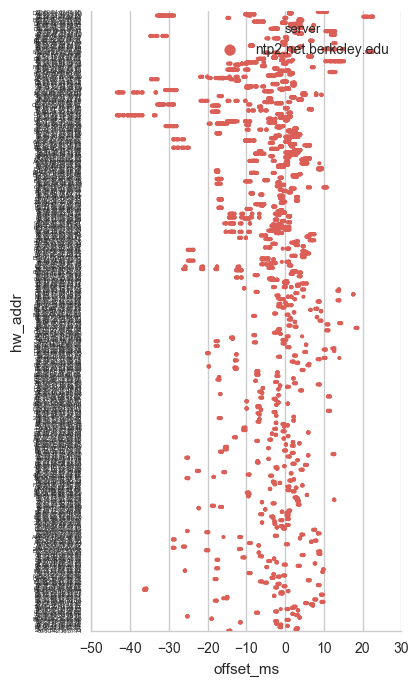

In [8]:
fig = pylab.figure(figsize=(4, 8))
ax = fig.add_subplot(1, 1,1 )

sns.stripplot(x="offset_ms", y="hw_addr",hue='server', # 
              data = ntpdf[ntpdf.server.isin([#'ntp1.net.berkeley.edu', 
                                              'ntp2.net.berkeley.edu', 
                                              #'time.mit.edu'
                ])],
              jitter=False, size=3, color=".3", #split=True,
              linewidth=0, axes=ax, palette= sns.color_palette("hls", 3),)
sns.despine(trim=True)
zed = [tick.label.set_fontsize(4) for tick in pylab.gca().yaxis.get_major_ticks()]
#pylab.figure("NTP time offset to {}")